## 1. Riduzione dello Spazio di Confronto (Blocking e Sorted Neighbourhood)

Per evitare confronti massivi tra ogni record (un’operazione computazionalmente onerosa), si applicano tecniche per restringere lo spazio di confronto. In questo approccio vengono utilizzate strategie in serie:

### Blocking per Settore e per Città
- **Descrizione:**  
  I record vengono raggruppati in blocchi in base a valori condivisi.
  - **Settore:** Le aziende vengono suddivise per settore industriale, poiché quelle dello stesso settore hanno maggiori probabilità di essere simili.
  - **Città:** Si applica un ulteriore livello di blocking basato sulla città, restringendo il confronto ai record geograficamente vicini.
  
- **Esempio pratico:**  
  Immagina un dataset con aziende nei settori "Tecnologia", "Sanità" e "Finanza", localizzate in città come "Milano", "Roma" e "Torino". Verranno confrontate solo le aziende che appartengono allo stesso settore **e** alla stessa città.

### Sorted Neighbourhood
- **Descrizione:**  
  Dopo aver applicato il blocking, i record vengono ordinati in base al nome dell’azienda. Solo i record vicini, all’interno di una finestra mobile (ad esempio, 5 record consecutivi), vengono confrontati.
  
- **Esempio pratico:**  
  Considera una lista ordinata alfabeticamente:
  - `AlphaTech`
  - `Alphatech Solutions`
  - `Beta Corp`
  - `Gamma Inc`
  
  Solo "AlphaTech" e "Alphatech Solutions" verranno confrontati, evidenziando possibili duplicati anche se presentano leggere differenze.

---

## 2. Valutazione della Similarità

Una volta ottenute le coppie candidate tramite blocking e sorted neighbourhood, si procede a misurare la somiglianza tra i record.

### Confronto del Nome dell’Azienda con Algoritmi di Similarità
- **Jaro-Winkler:**  
  Questo algoritmo misura il grado di similarità tra due stringhe, gestendo variazioni, errori di battitura e trasposizioni.
  
  - **Funzionamento:**  
    L'algoritmo calcola il numero di caratteri corrispondenti, valuta le trasposizioni e applica un bonus per prefissi comuni.
  
  - **Esempio pratico:**  
    Confrontando "MARTHA" e "MARHTA", nonostante l'inversione di "T" e "H", il punteggio potrebbe essere alto (ad esempio, 0.94), indicando una forte somiglianza.

### Confronti Esatti per Altri Attributi
- **Descrizione:**  
  Per attributi come settore e città, si utilizza un confronto esatto: due record sono considerati corrispondenti solo se i valori sono identici.
  
- **Esempio pratico:**  
  Se due record indicano "Tecnologia" come settore e "Roma" come città, il confronto esatto restituisce una corrispondenza perfetta (valore 1). Se anche uno solo dei due valori differisce, la corrispondenza fallisce (valore 0).

---

## 3. Definizione di Regole per il Matching

Dopo aver calcolato i punteggi di similarità per ogni coppia, è necessario definire regole per decidere se due record rappresentano la stessa entità.

### Impostazione di Soglie di Similarità
- **Descrizione:**  
  Si stabiliscono delle soglie minime che il punteggio di similarità deve raggiungere affinché una coppia sia considerata un match.
  
- **Esempio pratico:**  
  Si può decidere che un punteggio Jaro-Winkler superiore a 0.90 indichi che i nomi sono sufficientemente simili per suggerire un duplicato.

### Combinazione di Condizioni su Più Attributi
- **Descrizione:**  
  Le regole di matching combinano il punteggio del nome con confronti esatti per altri attributi (settore e città).
  
- **Esempio pratico:**  
  Una coppia di record viene considerata un match se:
  - **Opzione 1:** Il punteggio del nome è superiore a 0.90;  
    **oppure**
  - **Opzione 2:** Il punteggio del nome è compreso tra 0.80 e 0.92 **e** sia il settore che la città coincidono esattamente.
  
  Questo approccio riduce i falsi positivi, identificando come match solo le coppie con una forte corrispondenza in tutti i campi critici.

### Bilanciamento tra Precisione e Recall
- **Descrizione:**  
  Le soglie e le regole vengono ottimizzate per bilanciare:
  - **Precisione:** La percentuale di match corretti tra quelli identificati.
  - **Recall:** La percentuale di duplicati reali individuati.
  
- **Esempio pratico:**  
  Soglie troppo rigide possono portare a perdere duplicati reali (basso recall), mentre soglie troppo permissive possono includere troppi falsi positivi (bassa precisione). Un tuning accurato consente di raggiungere un equilibrio ottimale.

---

Questa spiegazione mostra come:
- Le tecniche di **blocking** (per settore e città) e **sorted neighbourhood** riducano il numero di confronti,
- L'algoritmo **Jaro-Winkler** (insieme a confronti esatti) valuti la similarità tra record,
- E le regole di matching combinino questi elementi per identificare duplicati in modo efficace, bilanciando precisione e recall.


In [6]:
import pandas as pd
import recordlinkage

# 1) Caricamento e pre-elaborazione dati
schema_file = "main_outputs/final_mediated_schema.csv"
df = pd.read_csv(schema_file)

# Seleziona alcune colonne di esempio
df = df[['company_name', 'industry', 'headquarters_city']]
df.dropna(subset=['company_name'], inplace=True)

print(f"Numero di record iniziali: {len(df)}")

# 2) Creazione di un blocking non troppo restrittivo
indexer = recordlinkage.Index()
indexer.add(recordlinkage.index.Block('industry'))
indexer.add(recordlinkage.index.Block('headquarters_city'))
indexer.add(recordlinkage.index.SortedNeighbourhood('company_name', window=5))

candidate_pairs = indexer.index(df)
print(f"Numero di coppie candidate: {len(candidate_pairs)}")

# 3) Definizione delle regole di confronto
compare = recordlinkage.Compare()

compare.string('company_name', 'company_name', method='jarowinkler', label='name_sim')
compare.exact('industry', 'industry', label='industry_exact')
compare.exact('headquarters_city', 'headquarters_city', label='city_exact')

# 4) Calcolo della matrice di similarità
similarity_matrix = compare.compute(candidate_pairs, df)
print(f"Dimensioni della similarity_matrix: {similarity_matrix.shape}")

# 5) Selezione coppie considerate match (esempio di regola)
matches = similarity_matrix[
    (similarity_matrix['name_sim'] > 0.80) & (similarity_matrix['name_sim'] < 0.92) |
    (similarity_matrix['name_sim'] > 0.9) & (similarity_matrix['industry_exact'] == 1) &
     (similarity_matrix['city_exact'] == 1)
]

print(f"Numero di coppie finali considerate 'match': {len(matches)}")

# 6) Per avere i valori effettivi dei record, facciamo un "join" con df originale

# a) Resettiamo l'indice (che è una MultiIndex di coppie) per avere due colonne: 'level_0' e 'level_1'
matches = matches.reset_index()
matches.rename(columns={'level_0':'id_left','level_1':'id_right'}, inplace=True)

# Ora 'id_left' e 'id_right' sono gli indici del DataFrame df

# b) Uniamo i valori delle colonne originali di 'df' per id_left
matches = matches.merge(df, left_on='id_left', right_index=True, how='left', suffixes=('', '_left'))

# c) Uniamo i valori delle colonne originali di 'df' per id_right
matches = matches.merge(df, left_on='id_right', right_index=True, how='left', suffixes=('_left', '_right'))

# Adesso, matches ha le colonne del record "di sinistra" (id_left) e del record "di destra" (id_right)
# Es. company_name_left, industry_left, headquarters_city_left, company_name_right, industry_right, etc.
# E contiene anche le colonne di similarità: name_sim, industry_exact, city_exact

# INFINE, eliminiamo da matches, tutte le righe in cui i campi di company_name hanno esattamente la stessa identica stringa
matches = matches[matches['company_name_left'] != matches['company_name_right']]

# 7) Salvataggio in CSV con tutti i dati
matches.to_csv("matched_companies_detailed.csv", index=False)
print("✅ File 'matched_companies_detailed.csv' generato con i valori dei record affiancati!")


C:\Users\luca-\AppData\Local\Temp\ipykernel_18428\2525519434.py:6: DtypeWarning: Columns (2,5,6,7,9,14,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(schema_file)


Numero di record iniziali: 75793
Numero di coppie candidate: 9515230
Dimensioni della similarity_matrix: (9515230, 3)
Numero di coppie finali considerate 'match': 118429
✅ File 'matched_companies_detailed.csv' generato con i valori dei record affiancati!


## Cosa contiene il file finale

Dopo questo passaggio, il CSV `matched_companies_detailed.csv` avrà le colonne:

- `id_left` e `id_right`: gli indici Pandas dei due record matchati.
- `name_sim`, `industry_exact`, `city_exact`: le metriche di somiglianza calcolate.
- `company_name_left`, `industry_left`, `headquarters_city_left`: i valori presi dal DataFrame originale per il record "di sinistra".
- `company_name_right`, `industry_right`, `headquarters_city_right`: idem per il record "di destra".

In questo modo, visivamente puoi ispezionare se `company_name_left` e `company_name_right` sembrano davvero la stessa azienda, controllare se `industry_left` = `industry_right`, e così via.

---
## Convertire ground_truth.json in CSV

In [7]:
import json
import csv

# Leggiamo il JSON
with open("data/ground_truth_1.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Creiamo il file CSV in scrittura
with open("data/ground_truth.csv", "w", encoding="utf-8", newline="") as csv_file:
    writer = csv.writer(csv_file)
    # Scriviamo l'header
    writer.writerow([
        "company_a", "industry_a", "country_a", "source_a",
        "company_b", "industry_b", "country_b", "source_b",
        "label"
    ])

    # Per ogni record in data["ground_truth"]
    for record in data["ground_truth"]:
        pairs = record["pairs"]
        # Assumiamo che pairs contenga esattamente 2 elementi:
        pair_a, pair_b = pairs[0], pairs[1]

        # Estraiamo i valori per la prima azienda
        company_a = pair_a.get("company-name", "")
        industry_a = pair_a.get("industry", "")
        country_a = pair_a.get("country", "")
        source_a = pair_a.get("source", "")

        # Estraiamo i valori per la seconda azienda
        company_b = pair_b.get("company-name", "")
        industry_b = pair_b.get("industry", "")
        country_b = pair_b.get("country", "")
        source_b = pair_b.get("source", "")

        # Se il campo industry è una lista, uniamo gli elementi in una stringa
        if isinstance(industry_a, list):
            industry_a = "; ".join(industry_a)
        if isinstance(industry_b, list):
            industry_b = "; ".join(industry_b)

        # Convertiamo eventuali None in stringhe vuote
        country_a = country_a or ""
        country_b = country_b or ""
        industry_a = industry_a or ""
        industry_b = industry_b or ""

        # Impostiamo la label: 1 se match è true, 0 se false
        label = 1 if record.get("match", False) else 0

        # Scriviamo la riga nel CSV
        writer.writerow([
            company_a, industry_a, country_a, source_a,
            company_b, industry_b, country_b, source_b,
            label
        ])

print("Conversione completata! File 'ground_truth.csv' generato.")


Conversione completata! File 'ground_truth.csv' generato.


---
## Calcolo delle metriche di recision Recall e F-Measure

In [8]:
import pandas as pd

# Path dei file (aggiorna con i percorsi reali)
pairwise_file = 'matched_companies_detailed.csv'
groundtruth_file = 'data/ground_truth.csv'

# Caricamento dei file
pairwise = pd.read_csv(pairwise_file)
groundtruth = pd.read_csv(groundtruth_file)

# Funzione di supporto per normalizzare i nomi di società (rimuove spazi e usa lowercase)
def normalize_name(name):
    return name.strip().lower() if isinstance(name, str) else str(name).lower()

# Funzione per ottenere una tupla ordinata, così che l'ordine non conti
def normalize_pair(row, col1, col2):
    left = normalize_name(row[col1])
    right = normalize_name(row[col2])
    return tuple(sorted([left, right]))

# Creiamo la colonna 'normalized_pair' in entrambi i dataset
pairwise['normalized_pair'] = pairwise.apply(
    lambda x: normalize_pair(x, 'company_name_left', 'company_name_right'), axis=1
)
groundtruth['normalized_pair'] = groundtruth.apply(
    lambda x: normalize_pair(x, 'company_a', 'company_b'), axis=1
)

# Convertiamo in insiemi per confronto
pairwise_set = set(pairwise['normalized_pair'])
groundtruth_set = set(groundtruth['normalized_pair'])

# Intersezione tra le coppie del dataset pairwise e quelle della ground truth (tutte, indipendentemente dalla label)
intersection = pairwise_set.intersection(groundtruth_set)

# Filtriamo la ground truth per ottenere solo le coppie con label 1 (cioè i match veri)
groundtruth_true_set = set(groundtruth[groundtruth['label'] == 1]['normalized_pair'])

# Calcoliamo il numero di coppie dell'intersezione che hanno label 1
tp = len(intersection.intersection(groundtruth_true_set))

# Calcolo delle metriche:
# - Precisione: fra le coppie previste (cioè quelle in intersezione), quanti sono corretti (label=1)
precision = tp / len(intersection) if len(intersection) else 0
# - Recall: fra tutte le coppie corrette presenti in ground truth, quanti sono stati trovati
recall = tp / len(groundtruth_true_set) if len(groundtruth_true_set) else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

# Output dei risultati
print(f"Numero di coppie in pairwise: {len(pairwise_set)}")
print(f"Numero di coppie in ground truth: {len(groundtruth_set)}")
print(f'Numero di coppie in ground truth con label a 1: {len(groundtruth_true_set)}')
print(f"Numero di coppie in intersezione: {len(intersection)}")
print(f"Numero di coppie nell'intersezione con label 1: {tp}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")


Numero di coppie in pairwise: 98726
Numero di coppie in ground truth: 211
Numero di coppie in ground truth con label a 1: 75
Numero di coppie in intersezione: 202
Numero di coppie nell'intersezione con label 1: 73
Precision: 0.3614
Recall: 0.9733
F1-Score: 0.5271


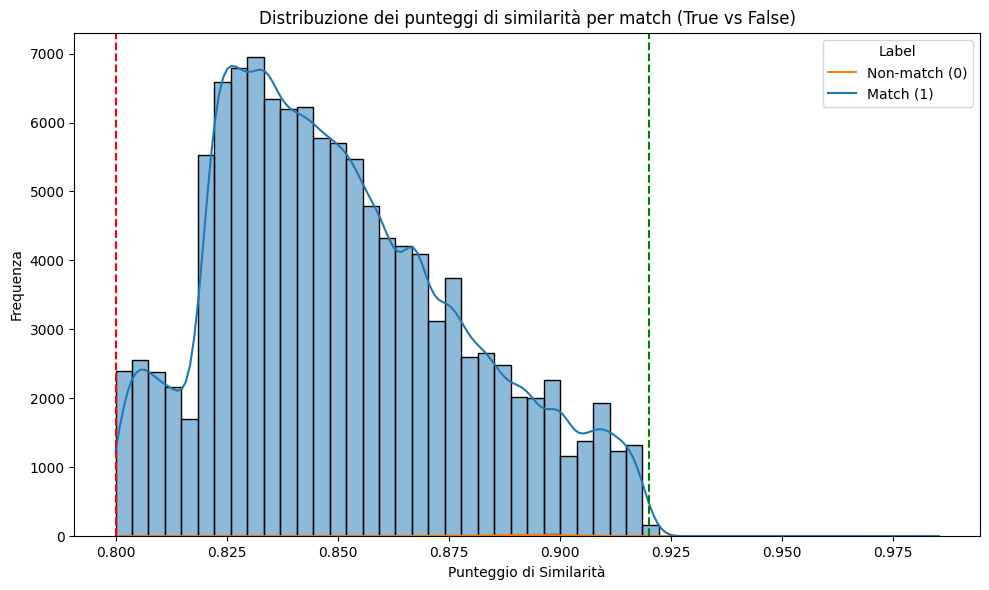

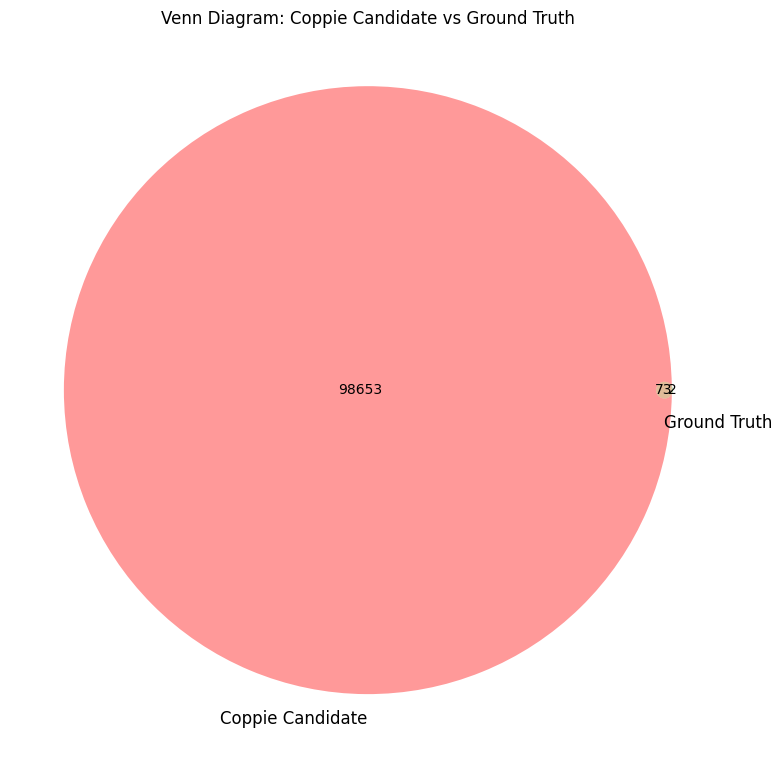

C:\Users\luca-\AppData\Local\Temp\ipykernel_18428\1938697635.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=match_counts.index, y=match_counts.values, palette='viridis')


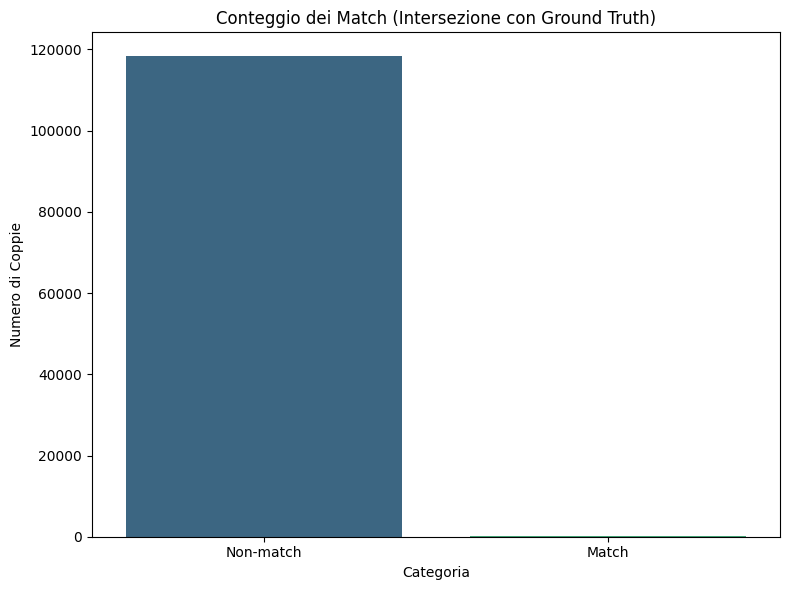

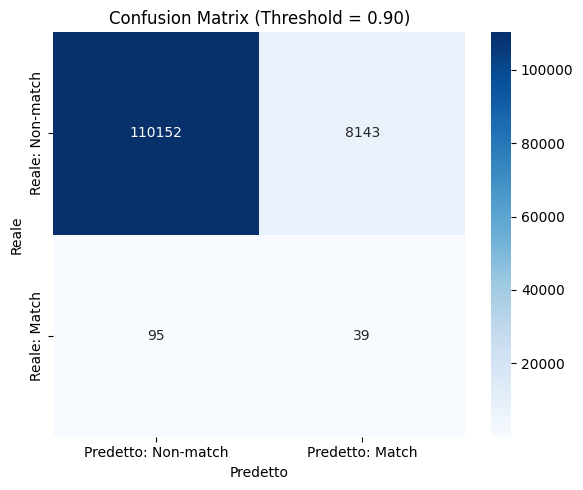

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from sklearn.metrics import precision_recall_curve, confusion_matrix

# -------------------------------
# Carica i dati
# -------------------------------
pairwise = pd.read_csv('matched_companies_detailed.csv')
groundtruth = pd.read_csv('data/ground_truth.csv')

# Funzione per normalizzare i nomi
def normalize_name(name):
    return name.strip().lower() if isinstance(name, str) else str(name).lower()

# Crea la colonna 'normalized_pair' in entrambi i dataset
pairwise['normalized_pair'] = pairwise.apply(
    lambda row: tuple(sorted([normalize_name(row['company_name_left']),
                                normalize_name(row['company_name_right'])])),
    axis=1
)
groundtruth['normalized_pair'] = groundtruth.apply(
    lambda row: tuple(sorted([normalize_name(row['company_a']),
                                normalize_name(row['company_b'])])),
    axis=1
)

# Crea un set per la ground truth con label 1
groundtruth_true_set = set(groundtruth[groundtruth['label'] == 1]['normalized_pair'])

# Crea la colonna 'label' in pairwise basata sulla ground truth:
# 1 se la coppia è presente in ground truth, 0 altrimenti
pairwise['label'] = pairwise['normalized_pair'].apply(lambda x: 1 if x in groundtruth_true_set else 0)

# -------------------------------
# Grafico 1: Histogramma dei punteggi di similarità per match vs non-match
# -------------------------------
plt.figure(figsize=(10, 6))
sns.histplot(data=pairwise, x='name_sim', hue='label', bins=50, kde=True)
plt.axvline(x=0.80, color='red', linestyle='--', label='Soglia 0.80')
plt.axvline(x=0.92, color='green', linestyle='--', label='Soglia 0.92')
plt.title('Distribuzione dei punteggi di similarità per match (True vs False)')
plt.xlabel('Punteggio di Similarità')
plt.ylabel('Frequenza')
plt.legend(title='Label', labels=['Non-match (0)', 'Match (1)'])
plt.tight_layout()
plt.show()

# -------------------------------
# Grafico 2: Venn Diagram delle coppie candidate vs Ground Truth (con label 1)
# -------------------------------
candidate_set = set(pairwise['normalized_pair'])
gt_set = groundtruth_true_set

plt.figure(figsize=(8, 8))
venn2(
    subsets=(len(candidate_set - gt_set), 
             len(gt_set - candidate_set), 
             len(candidate_set.intersection(gt_set))),
    set_labels=('Coppie Candidate', 'Ground Truth')
)
plt.title("Venn Diagram: Coppie Candidate vs Ground Truth")
plt.tight_layout()
plt.show()

# -------------------------------
# Grafico 3: Conteggio dei Match tra Candidate e Ground Truth
# -------------------------------
match_counts = pairwise['label'].value_counts().rename(index={0: 'Non-match', 1: 'Match'})
plt.figure(figsize=(8, 6))
sns.barplot(x=match_counts.index, y=match_counts.values, palette='viridis')
plt.title("Conteggio dei Match (Intersezione con Ground Truth)")
plt.xlabel("Categoria")
plt.ylabel("Numero di Coppie")
plt.tight_layout()
plt.show()

# -------------------------------
# Grafico 4: Confusion Matrix per un threshold di similarità
# (Si assume che l'algoritmo predica match se name_sim >= threshold)
# -------------------------------
threshold = 0.9  # Scegli una soglia per predire un match
pairwise['predicted'] = (pairwise['name_sim'] >= threshold).astype(int)
cm = confusion_matrix(pairwise['label'], pairwise['predicted'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predetto: Non-match', 'Predetto: Match'],
            yticklabels=['Reale: Non-match', 'Reale: Match'])
plt.title("Confusion Matrix (Threshold = {:.2f})".format(threshold))
plt.ylabel("Reale")
plt.xlabel("Predetto")
plt.tight_layout()
plt.show()
